In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
pd.set_option('display.max_columns', None)

In [ ]:
path='train_results_M3_final.parquet'
dfo=pd.read_parquet(path)


In [3]:
df=dfo.copy()
df=df[df['entry_allowed']==True]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3242 entries, 0 to 3958
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   signal_ts          3242 non-null   datetime64[ms]
 1   open               3242 non-null   float64       
 2   high               3242 non-null   float64       
 3   low                3242 non-null   float64       
 4   close              3242 non-null   float64       
 5   ticks              3242 non-null   uint32        
 6   bid_vol_sum        3242 non-null   float64       
 7   ask_vol_sum        3242 non-null   float64       
 8   bid_last           3242 non-null   float64       
 9   ask_last           3242 non-null   float64       
 10  n_bars_5s_signal   3242 non-null   uint32        
 11  candle_dir         3242 non-null   int32         
 12  open_1             3242 non-null   float64       
 13  high_1             3242 non-null   float64       
 14  low_1        

# Graficos esenciales para validar la calidad de los trades generados

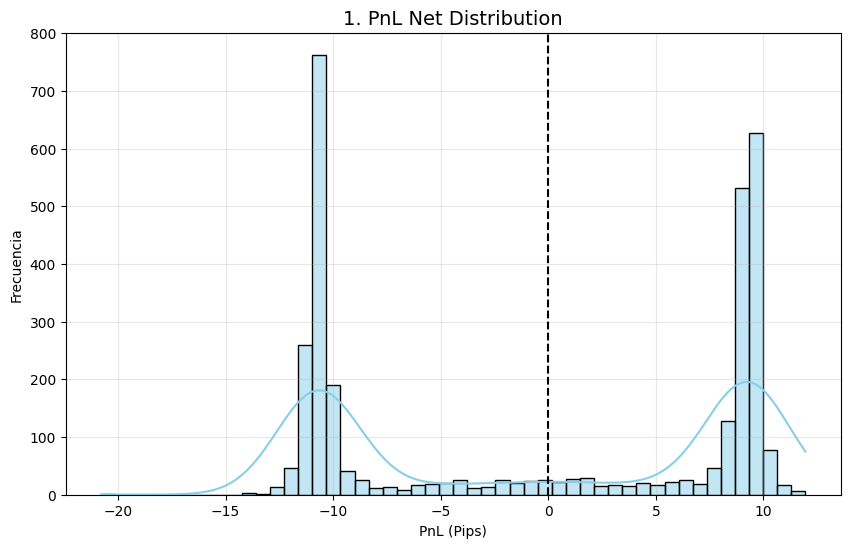

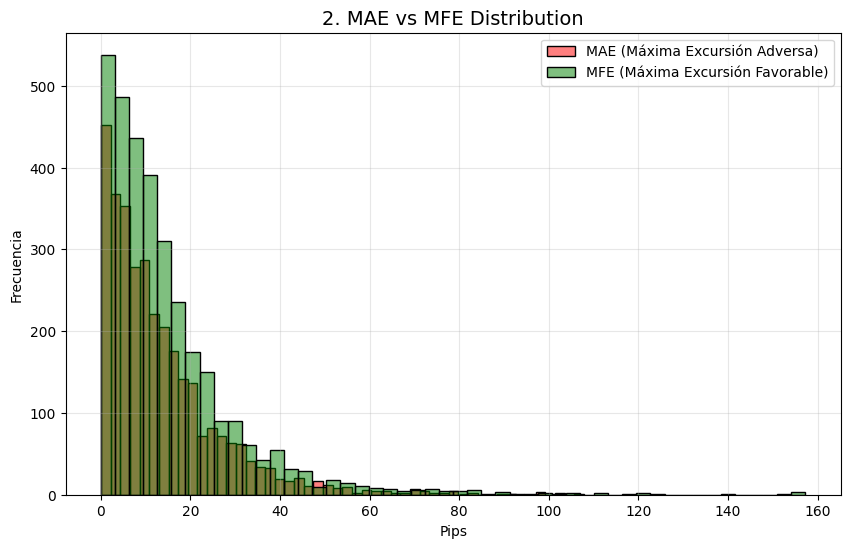

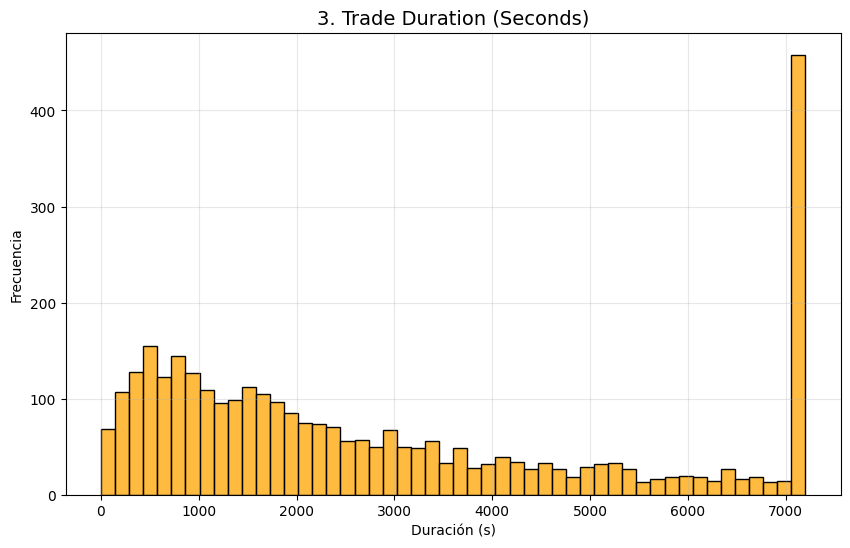

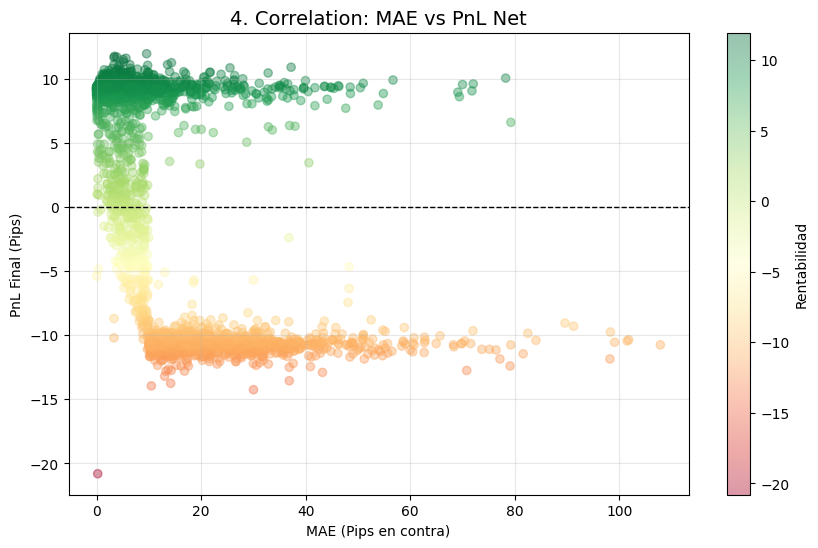

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def export_charts_one_by_one(df):
    df_clean = df.dropna(subset=["pnl_pips_net", "mae_pips", "mfe_pips", "duration_s"])
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean["pnl_pips_net"], bins=50, kde=True, color='skyblue')
    plt.axvline(0, color='black', linestyle='--', linewidth=1.5)
    plt.title("1. PnL Net Distribution", fontsize=14)
    plt.xlabel("PnL (Pips)")
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.show() 
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean["mae_pips"], bins=50, color='red', alpha=0.5, label='MAE (Máxima Excursión Adversa)')
    sns.histplot(df_clean["mfe_pips"], bins=50, color='green', alpha=0.5, label='MFE (Máxima Excursión Favorable)')
    plt.title("2. MAE vs MFE Distribution", fontsize=14)
    plt.xlabel("Pips")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean["duration_s"], bins=50, color='orange')
    plt.title("3. Trade Duration (Seconds)", fontsize=14)
    plt.xlabel("Duración (s)")
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean["mae_pips"], df_clean["pnl_pips_net"], alpha=0.4, c=df_clean["pnl_pips_net"], cmap='RdYlGn')
    plt.title("4. Correlation: MAE vs PnL Net", fontsize=14)
    plt.xlabel("MAE (Pips en contra)")
    plt.ylabel("PnL Final (Pips)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(alpha=0.3)
    plt.colorbar(label='Rentabilidad')
    plt.show()
export_charts_one_by_one(df)

# Me interesa saber que % de trades no estuve dentro de las reglas 10 pips sl y tp

In [7]:
trades_zona_muerta = df[df["pnl_pips_net"].between(-5, 5)]
cantidad = len(trades_zona_muerta)
total_trades = len(df)
porcentaje = (cantidad / total_trades) * 100
print(f"--- ANÁLISIS DE ZONA DE RUIDO (-5 a +5 pips) ---")
print(f"Total de trades en este rango: {cantidad}")
print(f"Porcentaje del total: {porcentaje:.2f}%")


--- ANÁLISIS DE ZONA DE RUIDO (-5 a +5 pips) ---
Total de trades en este rango: 318
Porcentaje del total: 9.81%


# graficamente contamos este 9.81%

>>> Motivos de salida en el rango -3 a +3 pips:
exit_reason
TIME    312
TP        4
SL        2
Name: count, dtype: int64

Total trades en rango: 318


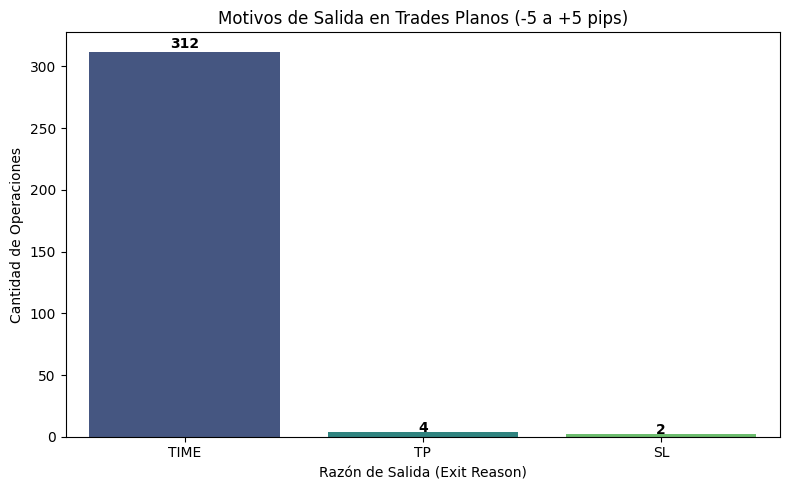

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
trades_rango = df[df["pnl_pips_net"].between(-5, 5)]
conteo_motivos = trades_rango["exit_reason"].value_counts()
print(">>> Motivos de salida en el rango -3 a +3 pips:")
print(conteo_motivos)
print(f"\nTotal trades en rango: {len(trades_rango)}")
plt.figure(figsize=(8, 5))
sns.barplot(x=conteo_motivos.index, y=conteo_motivos.values, hue=conteo_motivos.index, palette="viridis", legend=False)
plt.title("Motivos de Salida en Trades Planos (-5 a +5 pips)")
plt.xlabel("Razón de Salida (Exit Reason)")
plt.ylabel("Cantidad de Operaciones")
for i, v in enumerate(conteo_motivos.values):
    plt.text(i, v + (v*0.01), str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Analisis de duracion de los trades para ver anomalias

In [9]:
df["signal_ts"]     = pd.to_datetime(df["signal_ts"])
df["entry_ts_ideal"]= pd.to_datetime(df["entry_ts_ideal"])
df["entry_ts_real"] = pd.to_datetime(df["entry_ts_real"])
df["exit_price_ts"] = pd.to_datetime(df["exit_price_ts"])
df["side"] = np.where(df["signal"] == 1, "LONG", "SHORT")
df["win"]  = df["pnl_pips_net"] > 0
df["entry_after_signal_s"] = (df["entry_ts_real"] - df["signal_ts"]).dt.total_seconds()
df["entry_delay_calc_s"]   = (df["entry_ts_real"] - df["entry_ts_ideal"]).dt.total_seconds()
df["duration_s_calc"]      = (df["exit_price_ts"] - df["entry_ts_real"]).dt.total_seconds()
df.head(3)

,signal_ts,open,high,low,close,ticks,bid_vol_sum,ask_vol_sum,bid_last,ask_last,n_bars_5s_signal,candle_dir,open_1,high_1,low_1,close_1,dir_1,signal,entry_ts_ideal,entry_ts_real,open_right,high_right,low_right,close_right,ticks_right,bid_last_right,ask_last_right,bid_vol_sum_right,ask_vol_sum_right,entry_delay_s,in_news_window,good_time,good_news,entry_allowed,blocked_by_time,blocked_by_news,hard_exit_ts,exit_reason,exit_price_exec,pnl_pips_gross,pnl_pips_net,mae_pips,mfe_pips,first_touch_15p,spread_entry,spread_exit,exit_price_ts,duration_s,ratio_mfe_mae,target_15p,target_30p,target_50p,n_bars_5s_right,side,win,entry_after_signal_s,entry_delay_calc_s,duration_s_calc
0,2021-01-01 09:51:00,1.209460,1.209800,1.20931,1.209800,246,395.540001,396.480001,1.20978,1.20982,35,1,1.209455,1.209715,1.209360,1.209465,1,-1,2021-01-01 09:54:00,2021-01-01 09:54:00,1.209795,1.20980,1.209535,1.209535,20,1.20952,1.20955,93.870000,18.71,0,False,True,True,True,False,False,2021-01-01 11:54:00,TP,1.208795,7.25,6.75,0.05,28.50,MFE,0.3,0.5,2021-01-01 10:15:00,1260.0,190.000000,1.0,0.0,0.0,35,SHORT,True,180.0,0.0,1260.0
1,2021-01-01 10:36:00,1.208040,1.208355,1.20697,1.207340,506,756.040001,951.200003,1.20732,1.20736,36,-1,1.208180,1.208190,1.207855,1.208045,-1,1,2021-01-01 10:39:00,2021-01-01 10:39:00,1.207310,1.20737,1.207310,1.207370,13,1.20736,1.20738,17.250000,16.51,0,False,True,True,True,False,False,2021-01-01 12:39:00,TP,1.208310,9.30,8.80,3.65,15.60,MFE,0.2,0.3,2021-01-01 11:52:05,4385.0,4.160000,1.0,0.0,0.0,36,LONG,True,180.0,0.0,4385.0
2,2021-01-01 13:57:00,1.208735,1.208975,1.20835,1.208485,371,774.230006,364.770000,1.20848,1.20849,36,-1,1.208910,1.208965,1.208705,1.208760,-1,1,2021-01-01 14:00:00,2021-01-01 14:00:00,1.208490,1.20860,1.208475,1.208480,25,1.20847,1.20849,68.389999,16.42,0,False,True,True,True,False,False,2021-01-01 16:00:00,TP,1.209490,10.00,9.50,5.00,14.65,NONE,0.2,0.4,2021-01-01 14:19:35,1175.0,2.872549,0.0,0.0,0.0,36,LONG,True,180.0,0.0,1175.0


### Cálculo y análisis de la duración de los trades.

count    3242.000000
mean     2941.640962
std      2363.016357
min         0.000000
1%         77.050000
5%        265.000000
10%       455.000000
25%       950.000000
50%      2135.000000
75%      4601.250000
90%      7200.000000
95%      7200.000000
99%      7200.000000
max      7200.000000
Name: duration_s_calc, dtype: float64

Min duration: 0.0
Max duration: 7200.0


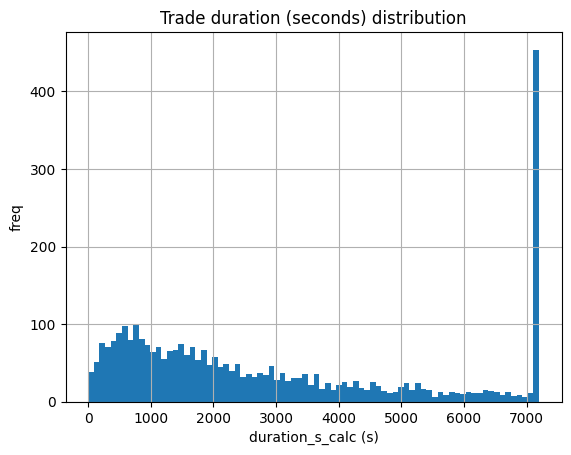

In [10]:
dur = df["duration_s_calc"]
print(dur.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
print("\nMin duration:", dur.min())
print("Max duration:", dur.max())
plt.figure()
dur.hist(bins=80)
plt.title("Trade duration (seconds) distribution")
plt.xlabel("duration_s_calc (s)")
plt.ylabel("freq")
plt.show()

# Trades anomalos con pnl

### Estadísticas descriptivas del PnL neto.

In [11]:
pnl_desc = df["pnl_pips_net"].describe(
    percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]
)
pnl_desc

count    3242.000000
mean       -0.346900
std         9.399117
min       -20.800000
1%        -11.950000
5%        -11.297500
10%       -11.000000
25%       -10.600000
50%         1.100000
75%         9.250000
90%         9.550000
95%         9.800000
99%        10.500000
max        11.950000
Name: pnl_pips_net, dtype: float64

### Identificación de outliers específicos en el PnL.

In [12]:
outliers = df[
    (df["pnl_pips_net"] <= -15) | (df["pnl_pips_net"] >= 15)
].copy()
print("Número de outliers |PnL| > 15:", len(outliers))
outliers[[
    "signal_ts",
    "entry_ts_real",
    "exit_price_ts",
    "side",
    "exit_reason",
    "pnl_pips_net",
    "mae_pips",
    "mfe_pips",
    "ratio_mfe_mae",
    "duration_s_calc",
    "entry_delay_s",
    "spread_entry",
    "spread_exit"
]].sort_values("pnl_pips_net")

Número de outliers |PnL| > 15: 1


,signal_ts,entry_ts_real,exit_price_ts,side,exit_reason,pnl_pips_net,mae_pips,mfe_pips,ratio_mfe_mae,duration_s_calc,entry_delay_s,spread_entry,spread_exit
1526,2022-09-07 12:27:00,2022-09-07 12:30:00,2022-09-07 12:30:00,SHORT,TP,-20.8,0.2,77.3,257.666667,0.0,0,0.3,0.3


# elimino el trade tiene tp pero pnl negativo

In [13]:
df = df.drop(index=1526).copy()
print("Rows after drop:", len(df))

Rows after drop: 3241


# Estadisticas basicas

### Impresión del conteo total de trades.

In [14]:
print("Total trades:", len(df))
side_counts = df["side"].value_counts()
side_pct = (side_counts / len(df) * 100).round(2)
display(pd.DataFrame({
    "n_trades": side_counts,
    "pct_%": side_pct
}))
winrate_total = df["win"].mean()
winrate_side = df.groupby("side")["win"].agg(
    win_rate="mean",
    n_trades="count"
).round(4)
print("Win rate total:", round(winrate_total, 4))
display(winrate_side)
exit_counts = df["exit_reason"].value_counts()
exit_pct = (exit_counts / len(df) * 100).round(2)
display(pd.DataFrame({
    "n_trades": exit_counts,
    "pct_%": exit_pct
}))
exit_by_side = pd.crosstab(
    df["side"],
    df["exit_reason"],
    margins=True,
    normalize="index"
).round(4)
exit_by_side

Total trades: 3241


,n_trades,pct_%
side,,
SHORT,1673,51.62
LONG,1568,48.38


Win rate total: 0.5134


,win_rate,n_trades
side,,
LONG,0.5057,1568
SHORT,0.5206,1673


,n_trades,pct_%
exit_reason,,
TP,1457,44.96
SL,1333,41.13
TIME,451,13.92


exit_reason,SL,TIME,TP
side,,,
LONG,0.4196,0.1358,0.4445
SHORT,0.4035,0.1423,0.4543
All,0.4113,0.1392,0.4496


# Baseline a comprobar final

### Cálculo de distribución de trades (Largas vs Cortas).

In [15]:
import numpy as np
import pandas as pd
start = df["signal_ts"].min()
end   = df["signal_ts"].max()
years = (end - start).total_seconds() / (365.25 * 24 * 3600)
R = df["pnl_pips_net"] / 10.0
n_trades = len(df)
n_long   = int((df["side"] == "LONG").sum())
n_short  = int((df["side"] == "SHORT").sum())
trades_per_year = n_trades / years if years > 0 else np.nan
win_rate_pct = (R > 0).mean() * 100
gross_profit_r = R[R > 0].sum()
gross_loss_r   = -R[R < 0].sum()
profit_factor  = gross_profit_r / gross_loss_r if gross_loss_r > 0 else np.nan
expectancy_r   = R.mean()
total_return_r = R.sum()
equity_r = R.cumsum()
peak_r   = equity_r.cummax()
dd_r     = peak_r - equity_r
max_dd_r = dd_r.max()
equity_r_last = float(equity_r.iloc[-1])
exit_counts = df["exit_reason"].value_counts()
n_tp   = int(exit_counts.get("TP", 0))
n_sl   = int(exit_counts.get("SL", 0))
n_time = int(exit_counts.get("TIME", 0))
tp_pct   = n_tp / n_trades * 100
sl_pct   = n_sl / n_trades * 100
time_pct = n_time / n_trades * 100
score = expectancy_r / max_dd_r if max_dd_r > 0 else np.nan
baseline = pd.Series({
    "start": start,
    "end": end,
    "years": round(years, 6),
    "n_trades": n_trades,
    "n_long": n_long,
    "n_short": n_short,
    "trades_per_year": round(trades_per_year, 6),
    "win_rate_pct": round(win_rate_pct, 4),
    "profit_factor": round(float(profit_factor), 6) if np.isfinite(profit_factor) else np.nan,
    "expectancy_r": round(float(expectancy_r), 6),
    "total_return_r": round(float(total_return_r), 2),
    "max_dd_r": round(float(max_dd_r), 4),
    "score": round(float(score), 6) if np.isfinite(score) else np.nan,
    "n_tp": n_tp,
    "n_sl": n_sl,
    "n_time": n_time,
    "tp_pct": round(tp_pct, 4),
    "sl_pct": round(sl_pct, 4),
    "time_pct": round(time_pct, 4),
    "equity_r_last": round(equity_r_last, 2),
    "passed_filters": True,
    "reason": "ok"
})
baseline

start              2021-01-01 09:51:00
end                2025-06-30 12:06:00
years                          4.49307
n_trades                          3241
n_long                            1568
n_short                           1673
trades_per_year             721.333105
win_rate_pct                   51.3422
profit_factor                 0.927488
expectancy_r                 -0.034059
total_return_r                 -110.39
max_dd_r                        139.06
score                        -0.000245
n_tp                              1457
n_sl                              1333
n_time                             451
tp_pct                         44.9553
sl_pct                         41.1293
time_pct                       13.9155
equity_r_last                  -110.39
passed_filters                    True
reason                              ok
dtype: object

# Aanlizar sin time, solo para entender mejor los datos

### Análisis de distribución de resultados (Wins vs Losses).

In [16]:
import numpy as np
import pandas as pd
df_core = df[df["exit_reason"].isin(["TP", "SL"])].copy()
start = df_core["signal_ts"].min()
end   = df_core["signal_ts"].max()
years = (end - start).total_seconds() / (365.25 * 24 * 3600)
R = df_core["pnl_pips_net"] / 10.0
n_trades = len(df_core)
n_long   = int((df_core["side"] == "LONG").sum())
n_short  = int((df_core["side"] == "SHORT").sum())
trades_per_year = n_trades / years if years > 0 else np.nan
win_rate_pct = (R > 0).mean() * 100
gross_profit_r = R[R > 0].sum()
gross_loss_r   = -R[R < 0].sum()
profit_factor  = gross_profit_r / gross_loss_r if gross_loss_r > 0 else np.nan
expectancy_r   = R.mean()
total_return_r = R.sum()
equity_r = R.cumsum()
peak_r   = equity_r.cummax()
dd_r     = peak_r - equity_r
max_dd_r = dd_r.max()
score = expectancy_r / max_dd_r if max_dd_r > 0 else np.nan
exit_counts = df_core["exit_reason"].value_counts()
n_tp = int(exit_counts.get("TP", 0))
n_sl = int(exit_counts.get("SL", 0))
baseline_core = pd.Series({
    "start": start,
    "end": end,
    "years": round(years, 6),
    "n_trades": n_trades,
    "n_long": n_long,
    "n_short": n_short,
    "trades_per_year": round(trades_per_year, 6),
    "win_rate_pct": round(win_rate_pct, 4),
    "profit_factor": round(float(profit_factor), 6) if np.isfinite(profit_factor) else np.nan,
    "expectancy_r": round(float(expectancy_r), 6),
    "total_return_r": round(float(total_return_r), 2),
    "max_dd_r": round(float(max_dd_r), 4),
    "score": round(float(score), 6) if np.isfinite(score) else np.nan,
    "n_tp": n_tp,
    "n_sl": n_sl,
    "tp_pct": round(n_tp / n_trades * 100, 4),
    "sl_pct": round(n_sl / n_trades * 100, 4),
    "equity_r_last": round(float(equity_r.iloc[-1]), 2),
    "passed_filters": True,
    "reason": "ok_no_TIME"
})
baseline_core

start              2021-01-01 09:51:00
end                2025-06-30 12:06:00
years                          4.49307
n_trades                          2790
n_long                            1355
n_short                           1435
trades_per_year             620.956298
win_rate_pct                   52.2222
profit_factor                  0.94419
expectancy_r                 -0.028435
total_return_r                  -79.34
max_dd_r                        125.59
score                        -0.000226
n_tp                              1457
n_sl                              1333
tp_pct                         52.2222
sl_pct                         47.7778
equity_r_last                   -79.34
passed_filters                    True
reason                      ok_no_TIME
dtype: object

# Curva de equity

### Visualización de la curva de equidad.

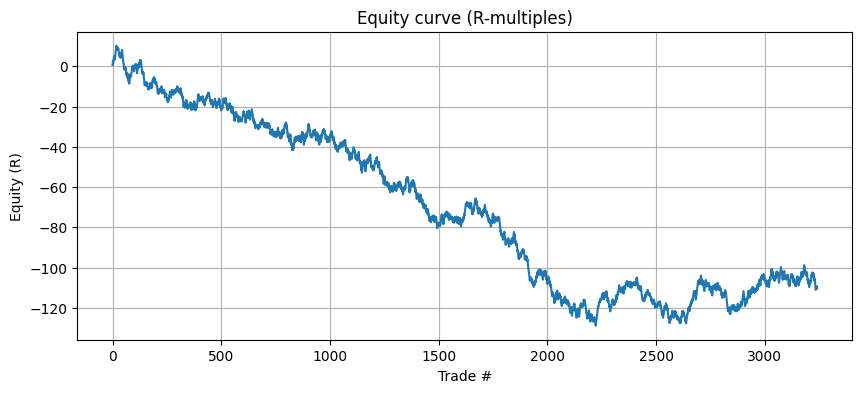

In [17]:
import matplotlib.pyplot as plt
import numpy as np
R = df["pnl_pips_net"] / 10.0
equity_r = R.cumsum()
plt.figure(figsize=(10,4))
plt.plot(equity_r.values)
plt.title("Equity curve (R-multiples)")
plt.xlabel("Trade #")
plt.ylabel("Equity (R)")
plt.grid(True)
plt.show()

# Racha de trades

### Cálculo del Win Rate global.

In [18]:
wins = (df["pnl_pips_net"] > 0).values
streaks = []
current = 1
for i in range(1, len(wins)):
    if wins[i] == wins[i-1]:
        current += 1
    else:
        streaks.append((wins[i-1], current))
        current = 1
streaks.append((wins[-1], current))
win_streaks = [l for w,l in streaks if w]
loss_streaks = [l for w,l in streaks if not w]
print("Max win streak:", max(win_streaks))
print("Max loss streak:", max(loss_streaks))
print("Avg win streak:", np.mean(win_streaks))
print("Avg loss streak:", np.mean(loss_streaks))

Max win streak: 11
Max loss streak: 11
Avg win streak: 2.0218712029161603
Avg loss streak: 1.9161603888213852


# Entiendo mejor como afecta el spreed y fee a la estrategia

### Cálculo del spread total (entrada + salida).

In [19]:
df["total_spread"] = df["spread_entry"] + df["spread_exit"]
df["total_spread"].describe()


count    3241.000000
mean        0.703579
std         0.761196
min         0.200000
25%         0.500000
50%         0.600000
75%         0.800000
max        25.700000
Name: total_spread, dtype: float64

### Cálculo del spread promedio.

In [20]:
print("Avg spread in pips:", df["total_spread"].mean())
print("Spread as % of SL:", df["total_spread"].mean() / 10 * 100, "%")

Avg spread in pips: 0.7035791422400332
Spread as % of SL: 7.035791422400331 %


# Veamos como se comporta la etiqueta

### Análisis de impacto del spread en el PnL.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df["ratio_raw"] = df["ratio_mfe_mae"].copy()
p99 = df["ratio_raw"].quantile(0.99)
df["ratio_clip"] = df["ratio_raw"].clip(lower=0, upper=p99)
df["ratio_log"] = np.log1p(df["ratio_clip"])
print("p99 ratio_raw:", p99)
df[["ratio_raw","ratio_clip","ratio_log"]].describe(percentiles=[0.5,0.9,0.95,0.99])

p99 ratio_raw: 193.95000000282425


,ratio_raw,ratio_clip,ratio_log
count,3241.000000,3241.000000,3241.000000
mean,9.982109,8.334099,1.127585
std,43.138145,26.726055,1.159011
min,0.000000,0.000000,0.000000
50%,1.115183,1.115183,0.749141
90%,15.145299,15.145299,2.781629
95%,34.950000,34.950000,3.582129
99%,193.950000,192.870000,5.267165
max,820.500000,193.950000,5.272743


### Gráfico de la evolución del balance de la cuenta.

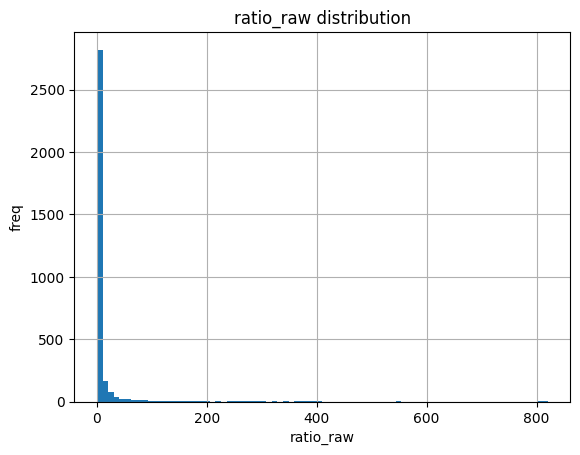

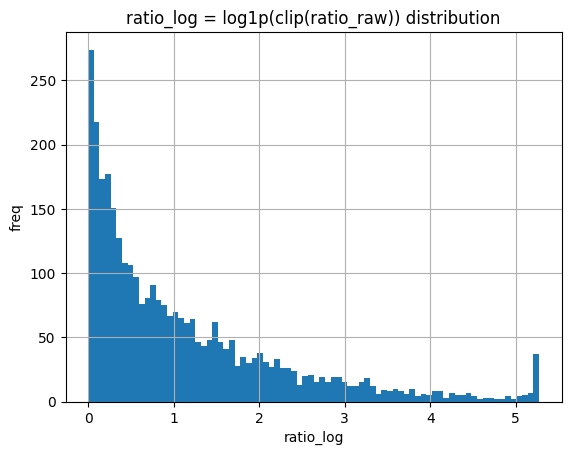

In [22]:
plt.figure()
df["ratio_raw"].hist(bins=80)
plt.title("ratio_raw distribution")
plt.xlabel("ratio_raw")
plt.ylabel("freq")
plt.show()
plt.figure()
df["ratio_log"].hist(bins=80)
plt.title("ratio_log = log1p(clip(ratio_raw)) distribution")
plt.xlabel("ratio_log")
plt.ylabel("freq")
plt.show()

### Definición de columna de ganancia/pérdida binaria.

In [23]:
df["win"] = df["pnl_pips_net"] > 0
by_win = df.groupby("win")["ratio_log"].describe(percentiles=[0.25,0.5,0.75,0.9]).T
by_win

win,False,True
count,1577.000000,1664.000000
mean,0.359064,1.855925
std,0.378584,1.179169
min,0.000000,0.000000
25%,0.099674,0.974872
50%,0.252788,1.563295
75%,0.498991,2.419817
90%,0.828171,3.542392
max,4.706523,5.272743


### Análisis descriptivo del ratio logarítmico por razón de salida.

In [24]:
by_exit = df.groupby("exit_reason")["ratio_log"].describe(percentiles=[0.25,0.5,0.75,0.9]).T
by_exit

exit_reason,SL,TIME,TP
count,1333.000000,451.000000,1457.000000
mean,0.311925,0.839688,1.962943
std,0.329990,0.613660,1.200061
min,0.000000,0.000000,0.144526
25%,0.082888,0.485865,1.084913
50%,0.207436,0.711385,1.692461
75%,0.413116,1.006058,2.580848
90%,0.753251,1.445808,3.703854
max,2.508049,4.388257,5.272743


### Discretización del ratio logarítmico en bins (deciles/quintiles).

In [25]:
df["ratio_bin"] = pd.qcut(df["ratio_log"], q=5, labels=False)
table = df.groupby("ratio_bin").agg(
    n=("ratio_bin","size"),
    win_rate=("win","mean"),
    pnl_mean=("pnl_pips_net","mean"),
    tp_rate=("exit_reason", lambda s: (s=="TP").mean()),
    sl_rate=("exit_reason", lambda s: (s=="SL").mean()),
    time_rate=("exit_reason", lambda s: (s=="TIME").mean()),
).reset_index()
table[["win_rate","pnl_mean","tp_rate","sl_rate","time_rate"]] = table[["win_rate","pnl_mean","tp_rate","sl_rate","time_rate"]].astype(float)
table

,ratio_bin,n,win_rate,pnl_mean,tp_rate,sl_rate,time_rate
0,0,649,0.007704,-10.353467,0.006163,0.961479,0.032357
1,1,648,0.168210,-6.753704,0.145062,0.699074,0.155864
2,2,648,0.527778,0.093441,0.362654,0.290123,0.347222
3,3,648,0.873457,6.441975,0.776235,0.101852,0.121914
4,4,648,0.990741,8.884259,0.958333,0.003086,0.038580


# Quedarnos con el df limpio eliminamos todo lo qeu no vamos a necesitar

### Selección de columnas relevantes para el conjunto de datos final.

In [26]:
keep_cols = [
    "signal_ts",
    "signal", "side",
    "entry_ts_real",
    "exit_price_ts",
    "duration_s_calc",
    "exit_reason",
    "pnl_pips_net",
    "entry_allowed",
    "blocked_by_time",
    "blocked_by_news",
    "in_news_window",
    "spread_entry",
    "spread_exit",
    "total_spread",
    "ratio_log",
    "ratio_clip", 
]
df_final = df[keep_cols].copy()
df_final = df_final.sort_values("signal_ts").reset_index(drop=True)
df_final.head(), df_final.shape

(            signal_ts  signal   side       entry_ts_real       exit_price_ts  \
 0 2021-01-01 09:51:00      -1  SHORT 2021-01-01 09:54:00 2021-01-01 10:15:00   
 1 2021-01-01 10:36:00       1   LONG 2021-01-01 10:39:00 2021-01-01 11:52:05   
 2 2021-01-01 13:57:00       1   LONG 2021-01-01 14:00:00 2021-01-01 14:19:35   
 3 2021-01-02 09:21:00       1   LONG 2021-01-02 09:24:00 2021-01-02 09:39:25   
 4 2021-01-02 12:45:00       1   LONG 2021-01-02 12:48:05 2021-01-02 13:00:35   
 
    duration_s_calc exit_reason  pnl_pips_net  entry_allowed  blocked_by_time  \
 0           1260.0          TP          6.75           True            False   
 1           4385.0          TP          8.80           True            False   
 2           1175.0          TP          9.50           True            False   
 3            925.0          SL        -11.00           True            False   
 4            750.0          TP          9.25           True            False   
 
    blocked_by_news  in_

### Visualización de las primeras filas del DataFrame final limpio.

In [27]:
df_final

,signal_ts,signal,side,entry_ts_real,exit_price_ts,duration_s_calc,exit_reason,pnl_pips_net,entry_allowed,blocked_by_time,blocked_by_news,in_news_window,spread_entry,spread_exit,total_spread,ratio_log,ratio_clip
0,2021-01-01 09:51:00,-1,SHORT,2021-01-01 09:54:00,2021-01-01 10:15:00,1260.0,TP,6.75,True,False,False,False,0.3,0.5,0.8,5.252273,190.000000
1,2021-01-01 10:36:00,1,LONG,2021-01-01 10:39:00,2021-01-01 11:52:05,4385.0,TP,8.80,True,False,False,False,0.2,0.3,0.5,1.640937,4.160000
2,2021-01-01 13:57:00,1,LONG,2021-01-01 14:00:00,2021-01-01 14:19:35,1175.0,TP,9.50,True,False,False,False,0.2,0.4,0.6,1.353913,2.872549
3,2021-01-02 09:21:00,1,LONG,2021-01-02 09:24:00,2021-01-02 09:39:25,925.0,SL,-11.00,True,False,False,False,0.3,0.4,0.7,0.066874,0.069161
4,2021-01-02 12:45:00,1,LONG,2021-01-02 12:48:05,2021-01-02 13:00:35,750.0,TP,9.25,True,False,False,False,0.3,0.3,0.6,1.282091,2.604167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2025-06-28 14:42:00,-1,SHORT,2025-06-28 14:45:00,2025-06-28 14:55:20,620.0,TP,9.50,True,False,False,False,0.7,0.6,1.3,3.077522,20.704545
3237,2025-06-28 15:03:00,1,LONG,2025-06-28 15:06:00,2025-06-28 15:19:05,785.0,SL,-10.60,True,False,False,False,0.1,0.7,0.8,0.013316,0.013405
3238,2025-06-29 13:30:00,1,LONG,2025-06-29 13:33:00,2025-06-29 13:47:40,880.0,TP,9.25,True,False,False,False,0.3,0.4,0.7,1.698566,4.466102
3239,2025-06-30 08:00:00,1,LONG,2025-06-30 08:03:00,2025-06-30 10:03:00,7200.0,TIME,-0.10,True,False,False,False,0.5,0.4,0.9,0.705886,1.025641
